Work in Progress. Will be updated by Friday. Zheyu Ni

This file cleans the Airbnb data. 
1. deleted $ sign and comma in price.
2. visualize price distribution base on different features
3. Price range (0, 800) covers 95\% of the listings
4. create a dummy for the listing without review data
5. check how many listings have hotel/motel in name and agree with their room_type

The remaing data file contains \% of the raw data

In [33]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [34]:
df = pd.read_csv('../listings_mar7_2023.csv')


In [35]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0         399.0
1          46.0
2         408.0
3          80.0
4        2138.0
          ...  
42446      40.0
42447      48.0
42448      46.0
42449      68.0
42450      48.0
Name: price, Length: 42451, dtype: float64

In [36]:
print(df['room_type'].value_counts())

Entire home/apt    29491
Private room       12180
Shared room          697
Hotel room            83
Name: room_type, dtype: int64


In [37]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [38]:
print(df['room_type'].value_counts())

Entire home/apt    29293
Private room       12051
Shared room          696
Hotel room           411
Name: room_type, dtype: int64


In [39]:
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True].sample(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14690,28764111,https://www.airbnb.com/rooms/28764111,20230307175359,2023-03-08,city scrape,greenleaf hotel,Hotel in downtown Long Beach. minutes away fro...,Residential area with many apartments.,https://a0.muscache.com/pictures/1827b99d-997b...,168467528,...,3.4,3.2,3.0,Exempt,t,31,0,3,0,0.1
7130,750726757465364939,https://www.airbnb.com/rooms/750726757465364939,20230307175359,2023-03-08,city scrape,queen bed hotel style suite,LA Suites is nestled in the heart of Beverly H...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,484477694,...,NaN,NaN,NaN,NaN,t,54,54,0,0,NaN


In [40]:
df.head(2)

#columns that are interesting:
# latitude
# longitude
# room_type
# property_type
# accommodates
# bathrooms_text
# number_of_reviews
# first_review
# last_reviews
# reviews_per_month


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,777451666060243581,https://www.airbnb.com/rooms/777451666060243581,20230307175359,2023-03-07,city scrape,Family oriented home,Relax with the whole family at this peaceful p...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,490709958,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,698097753730921190,https://www.airbnb.com/rooms/698097753730921190,20230307175359,2023-03-07,city scrape,方便易居驿站,NaN,NaN,https://a0.muscache.com/pictures/d5afff58-d576...,444692513,...,5.0,5.0,4.4,NaN,f,4,0,4,0,0.86


In [41]:
#column_names =[df.columns,df.dtypes]
#list(column_names)

df.price[0:10]

0     399.0
1      46.0
2     408.0
3      80.0
4    2138.0
5      55.0
6      60.0
7      55.0
8     129.0
9     107.0
Name: price, dtype: float64

In [42]:
df_priv = df[df['room_type']=='Private room'].copy()
df_homeapt = df[df['room_type']=='Entire home/apt'].copy()
df_share = df[df['room_type']=='Shared room'].copy()
df_hotel = df[df['room_type']=='Hotel room'].copy()

In [43]:
df_priv['latitude'].min()

33.33956

In [44]:
print(f"Range of latitude: {df_priv['latitude'].min()} to {df_priv['latitude'].max()}")
print(f"Range of longitude: {df_priv['longitude'].min()} to {df_priv['longitude'].max()}")

#https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
#One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
ratio_miles_to_onelat = 69
desired_lat_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_lats = df_priv['latitude'].max() - df_priv['latitude'].min()
diff_in_lats_in_miles = diff_in_lats*ratio_miles_to_onelat
bins_lats = int(np.round(diff_in_lats_in_miles/desired_lat_mile_per_bin))
print(f"Num of bins for latitude: {bins_lats}")


#One-degree of longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), and one second equals 80 feet.
ratio_miles_to_onelong = 54.6
desired_long_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_long = np.abs(df_priv['longitude'].max() - df_priv['longitude'].min())
diff_in_long_in_miles = diff_in_long*ratio_miles_to_onelong
bins_long = int(np.round(diff_in_long_in_miles/desired_long_mile_per_bin))
print(f"Num of bins for longitude: {bins_long}")



Range of latitude: 33.33956 to 34.81113
Range of longitude: -118.89972464431123 to -117.6534
Num of bins for latitude: 102
Num of bins for longitude: 68


In [45]:
#you have to add 1 to the bins because the very 1st element in the list is exclusive 
lats_bins_represent = np.linspace(df_priv['latitude'].min(),df_priv['latitude'].max(),bins_lats+1)
longs_bins_represent = np.linspace(df_priv['longitude'].min(),df_priv['longitude'].max(),bins_long+1)

# print(lats_bins_represent)
# print(longs_bins_represent)

In [46]:
H, xedges, yedges = np.histogram2d(df_priv['latitude'],df_priv['longitude'], bins=(bins_lats,bins_long) )

H = H.T

#if i do 0.1 mile per bin for both lats and longs, there is a bright yellow spot. It may so dense that it could be an outlier and over shadow it
#if you want to see, run the lines below multiple times to remove the outliers and run the histogram plotting cell

#I did a further analysis on exploring why their was an outlier
#there is one airbnb host that has multiple accounts and they have over 1500 listings
#they rent rooms in mansions I think. Seems absurd to have 1500 bedrooms available to rent all at one time
#https://www.airbnb.com/users/401130632/listings
#https://www.airbnb.com/users/144214204/listings
#I think I will definitely ignore them for this as this is a huge outlier
#http://insideairbnb.com/los-angeles
#      If you go here and scroll, you will see jino & scott own the most listings for private rooms
#
max_long_bin_num_priv = np.where(H == np.max(H))[0][0]
max_lat_bin_num_priv = np.where(H == np.max(H))[1][0]
print(H[max_long_bin_num_priv,max_lat_bin_num_priv])
H[max_long_bin_num_priv,max_lat_bin_num_priv] = 0 #when bins are represent 1 mile, do this to remove the outlier 

1781.0


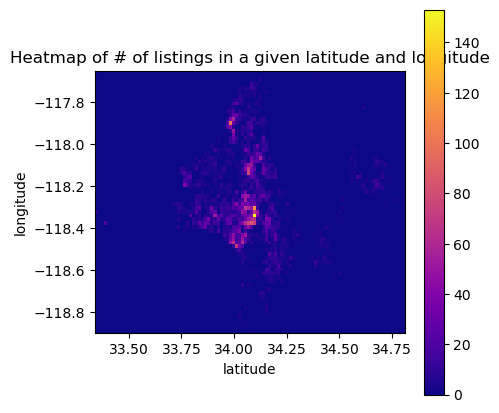

In [47]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of listings in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, H, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [48]:
lats_bins_represent[max_lat_bin_num_priv],longs_bins_represent[max_long_bin_num_priv]

(34.161907941176466, -118.45984535808374)

In [49]:
def get_listings_in_bin(df, lat_bin_num, long_bin_num):
    cond_gt_lats = df['latitude'] > lats_bins_represent[lat_bin_num]
    cond_lt_lats = df['latitude'] <= lats_bins_represent[lat_bin_num+1]
    cond_gt_long = df['longitude'] > longs_bins_represent[long_bin_num]
    cond_lt_long = df['longitude'] <= longs_bins_represent[long_bin_num+1]
    cut_df = df[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long].copy()
    return cut_df

In [50]:
outlier_df_priv = get_listings_in_bin(df_priv,max_lat_bin_num_priv,max_long_bin_num_priv)
outlier_df_priv.shape

(1781, 75)

In [51]:
min_max_scaled_H = H/np.max(H)

In [52]:
H.shape[1]

102

In [53]:
num_of_reviews_in_bin = np.zeros(H.shape)
for i in np.arange(0,H.shape[0],1):
    for j in np.arange(0,H.shape[1],1):
        dummy_df = get_listings_in_bin(df_priv,j,i)
        num_of_reviews_in_bin[i,j] = dummy_df['number_of_reviews'].sum()

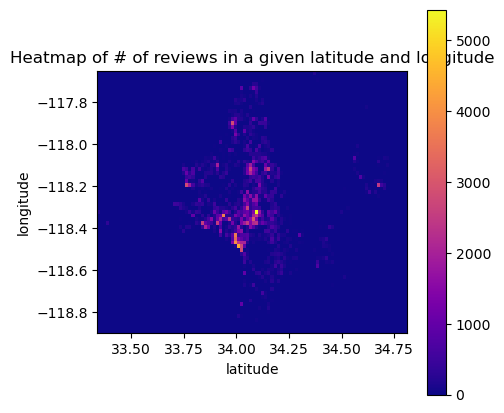

In [54]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of reviews in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, num_of_reviews_in_bin, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [55]:
min_max_scaled_reviews = num_of_reviews_in_bin/np.max(num_of_reviews_in_bin)

In [56]:
#this here is the amount of areas where the # of listings scale was larger than the # of reviews
#so whatever number is outputed it is saying that there are x amount of bin regions where their are more listings in the region than there are reviews
np.shape(np.where((min_max_scaled_H - min_max_scaled_reviews) > 0.3))[1]

3

In [57]:
#this here is the amount of areas where the # of listings scale was smaller than the # of reviews
#so whatever number is outputed it is saying that there are x amount of bin regions where their are more reviews in the region than there are listings.
np.shape(np.where((min_max_scaled_H - min_max_scaled_reviews) < -0.3))[1]

11

In [58]:
df_priv['hotspot_from_listings'] = 0
df_priv['hotspot_from_reviews'] = 0

In [59]:
for longs in np.arange(0,H.shape[0],1):
    for lats in np.arange(0,H.shape[1],1):
        cond_gt_lats = df_priv['latitude'] > lats_bins_represent[lats]
        cond_lt_lats = df_priv['latitude'] <= lats_bins_represent[lats+1]
        cond_gt_long = df_priv['longitude'] > longs_bins_represent[longs]
        cond_lt_long = df_priv['longitude'] <= longs_bins_represent[longs+1]
        df_priv.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_listings'] = min_max_scaled_H[longs,lats]
        df_priv.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews'] = min_max_scaled_reviews[longs,lats]

In [65]:
df_priv[df_priv['hotspot_from_listings'] > 0.9]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews
1028,825748400421713534,https://www.airbnb.com/rooms/825748400421713534,20230307175359,2023-03-09,city scrape,Lovely master bedroom Hollywood,Keep it simple at this peaceful master bedroom...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,50473564,...,4.50,NaN,t,4,0,4,0,2.00,1.0,0.45669
1426,22652682,https://www.airbnb.com/rooms/22652682,20230307175359,2023-03-08,previous scrape,Cozy suite in West Hollywood,This master bedroom suite is located in the he...,"The neighborhood is super Young, Trendy, safe ...",https://a0.muscache.com/pictures/638a7e9f-48b5...,67917706,...,5.00,NaN,f,1,0,1,0,0.02,1.0,0.45669
1586,38822606,https://www.airbnb.com/rooms/38822606,20230307175359,2023-03-08,previous scrape,West Hollywood Oasis,Enjoy the very best of Los Angeles in your own...,NaN,https://a0.muscache.com/pictures/323ae34f-8db3...,297197901,...,NaN,NaN,f,1,0,1,0,NaN,1.0,0.45669
1991,715785806889070022,https://www.airbnb.com/rooms/715785806889070022,20230307175359,2023-03-09,city scrape,1c. Downtown LA Small Private Room,Great Koreatown location next to downtown. It...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,53559956,...,4.21,NaN,f,14,2,12,0,2.50,1.0,0.45669
2097,551352841601839201,https://www.airbnb.com/rooms/551352841601839201,20230307175359,2023-03-08,city scrape,"Private Bedroom in Hollywood, Best Area in LA",The whole group will enjoy easy access to ever...,NaN,https://a0.muscache.com/pictures/0744b26f-117d...,183748836,...,4.40,NaN,f,22,1,21,0,3.22,1.0,0.45669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40163,654449221905969503,https://www.airbnb.com/rooms/654449221905969503,20230307175359,2023-03-08,previous scrape,Bc. Downtown LA Private Room,NOTE: this listing is not in West Hollywood ar...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,30906832,...,4.65,NaN,f,12,0,12,0,2.00,1.0,0.45669
41519,823220450884108744,https://www.airbnb.com/rooms/823220450884108744,20230307175359,2023-03-08,city scrape,HO.B1l - Affordable Private Room in Hollywood,We believe in responsible hosting. We are not ...,A larger-than-life symbol of the entertainment...,https://a0.muscache.com/pictures/miso/Hosting-...,478462358,...,NaN,NaN,f,11,1,10,0,NaN,1.0,0.45669
41541,804602665916169004,https://www.airbnb.com/rooms/804602665916169004,20230307175359,2023-03-08,city scrape,HD.B3y-Clean Private Room for 2 in Hollywood,Please DO NOT SEND A BOOKING REQUEST until you...,A larger-than-life symbol of the entertainment...,https://a0.muscache.com/pictures/miso/Hosting-...,478462358,...,5.00,NaN,f,11,1,10,0,1.00,1.0,0.45669
42183,558645865611872911,https://www.airbnb.com/rooms/558645865611872911,20230307175359,2023-03-08,city scrape,Adorable 1 Bedroom Guesthouse with Patio,Enjoy LA in style at this centrally located We...,East end of West Hollywood,https://a0.muscache.com/pictures/4bb484ae-1e0d...,1386381,...,4.78,NaN,f,5,4,1,0,4.08,1.0,0.45669


In [61]:
# plt.hist(df_priv['latitude'],bins=bins_lats)
# plt.show()

In [62]:
# plt.hist(df_priv['longitude'],bins=bins_long)
# plt.show()

In [63]:
#creates a map that has the shape of the united states

# fig = go.Figure(data=go.Scattergeo(
#         lon = df_priv['longitude'],
#         lat = df_priv['latitude'],
#         #text = 'Median house value: ' + housing['median_house_value'].astype(str),
#         #marker_size = (housing['bedrooms_per_household'])
#         ))
# fig.update_geos(fitbounds="locations")
# # fig.update_layout(
# #         title = 'Median house values of houses in California with marker size based on bedrooms per household',
# # )
# fig.show()

